# Bit-Interleaved Coded Modulation (BICM)

In this notebook you will learn about the principles of bit interleaved coded modulation (BICM) and focus on the interface between LDPC decoding and demapping for higher order modulation.
Further, we will discuss the idea of *all-zero codeword* simulations that enable bit-error rate simulations without having an explicit LDPC encoder available.
In the last part, we analyze what happens for mismatched demapping, e.g., if the SNR is unknown and show how min-sum decoding can have practical advantages in such cases.

*"From the coding viewpoint, the modulator, waveform channel, and demodulator together constitute a discrete channel with* $q$ *input letters and* $q'$ *output letters. [...] the real goal of the modulation system is to create the “best” discrete memoryless channel (DMC) as seen by the coding system."*
James L. Massey, 1974 [4, cf. preface in 5].

The fact that we usually separate modulation and coding into two individual tasks is strongly connected to the concept of bit-interleaved coded modulation (BICM) [1,2,5]. However, the joint optimization of coding and modulation has a long history, for example by Gottfried Ungerböck's *Trellis coded modulation* (TCM) [3] and we refer the interested reader to [1,2,5,6] for these *principles of coded modulation* [5].
Nonetheless, BICM has become the *de facto* standard in virtually any modern communication system due to its engineering simplicity.

In this notebook, you will use the following components:

* Mapper / demapper and the constellation class
* LDPC5GEncoder / LDPC5GDecoder
* AWGN channel
* BinarySource and GaussianPriorSource
* Interleaver / deinterleaver
* Scrambler / descrambler

## Table of Contents
* [System Block Diagram](#System-Block-Diagram)
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [A Simple BICM System](#A-Simple-BICM-System)
* [All-zero Codeword Simulations](#All-zero-Codeword-Simulations)
* [EXIT-Charts](#EXIT-Charts)
* [Mismatched Demapping and the Advantages of Min-sum Decoding](#Mismatched-Demapping-and-the-Advantages-of-Min-sum-Decoding)
* [References](#References)

## System Block Diagram

We introduce the following terminology:

- `u` denotes the `k` uncoded information bits
- `c` denotes the `n` codewords bits
- `x` denotes the complex-valued symbols after mapping `m` bits to one symbol
- `y` denotes the (noisy) channel observations
- `l_ch` denotes the demappers llr estimate on each bit `c`
- `u_hat` denotes the estimated information bits at the decoder output

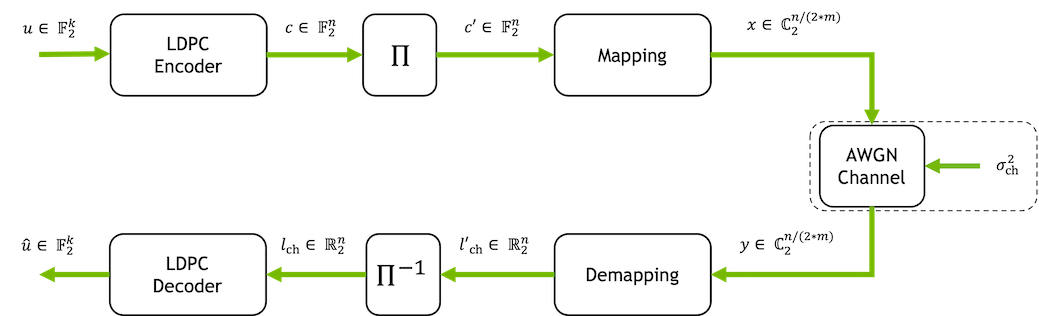

## GPU Configuration and Imports

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
# Load the required Sionna components
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder, LDPCBPDecoder
from sionna.fec.interleaving import RandomInterleaver, Deinterleaver
from sionna.fec.scrambling import Scrambler, Descrambler
from sionna.fec.utils import GaussianPriorSource, load_parity_check_examples, get_exit_analytic, plot_exit_chart, plot_trajectory
from sionna.utils import BinarySource, ebnodb2no, hard_decisions
from sionna.utils.plotting import PlotBER
from sionna.channel import AWGN

In [2]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## A Simple BICM System

The principle idea of higher order modulation is to map *m* bits to one (complex-valued) symbol *x*.
As each received symbol now contains information about *m* transmitted bits, the demapper produces *m* bit-wise LLR estimates (one per transmitted bit) where each LLR contains information about an individual bit.
This scheme allows a simple binary interface between demapper and decoder. 

From a decoder's perspective, the transmission of all *m* bits - mapped onto one symbol - could be modeled as if they have been transmitted over *m* different *surrogate* channels with certain properties as shown in the figure below.

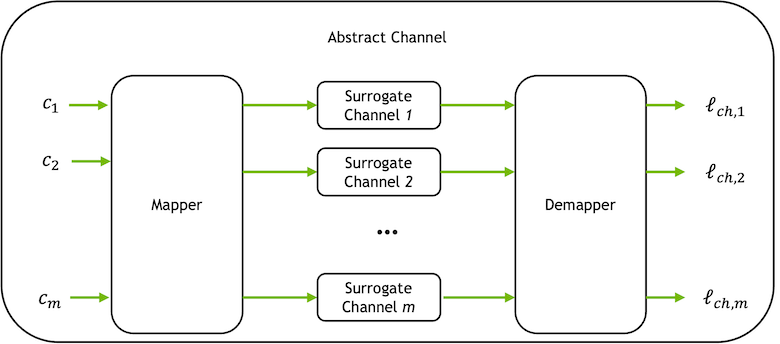


In the following, we are now interested in the LLR distribution at the decoder input (= demapper output) for each of these *surrogate* channels (denoted as *bit-channels* in the following).
Please note that in some scenario these surrogate channels can share the same statistical properties, e.g., for QPSK, both bit-channels behave equally due to symmetry.

Advanced note: the *m* binary LLR values are treated as independent estimates which is not exactly true for higher order modulation. As a result, the sum of the *bitwise* mutual information of all *m* transmitted bits does not exactly coincide with the *symbol-wise* mutual information describing the relation between channel input / output from a symbol perspective.
However, in practice the (small) losses are usually neglected if a QAM with a rectangular grid and Gray labeling is used.

### Constellations and Bit-Channels

Let us first look at some higher order constellations. 

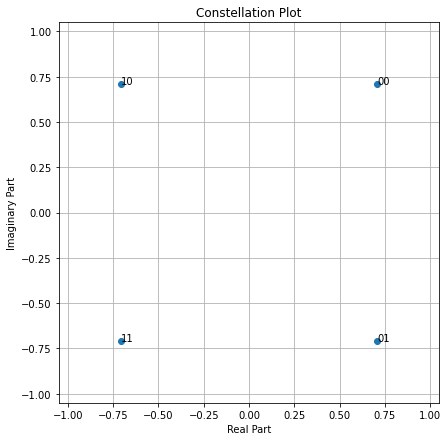

In [3]:
# show QPSK constellation
constellation = Constellation("qam", num_bits_per_symbol=2)
constellation.show();

Assuming an AWGN channel and QPSK modulation all symbols behave equally due to the symmetry (all constellation points are located on a circle). However, for higher order modulation such as 16-QAM the situation changes and the LLRs after demapping are not equally distributed anymore.

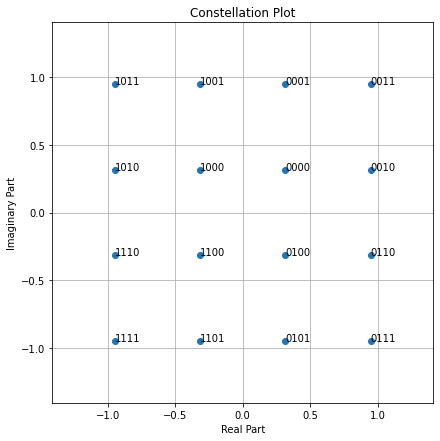

In [4]:
# generate 16QAM with Gray labeling
constellation = Constellation("qam", num_bits_per_symbol=4)
constellation.show();

We can visualize this by applying *a posteriori propability* (APP) demapping and plotting of the corresponding LLR distributions for each of the *m* transmitted bits per symbol individually. 
As each bit could be either *0* or *1*, we flip the signs of the LLRs *after* demapping accordingly. Otherwise, we would observe two symmetric distributions per bit *b_i* for *b_i=0* and *b_i=1*, respectively.
See [10] for a closed-form approximation and further details.

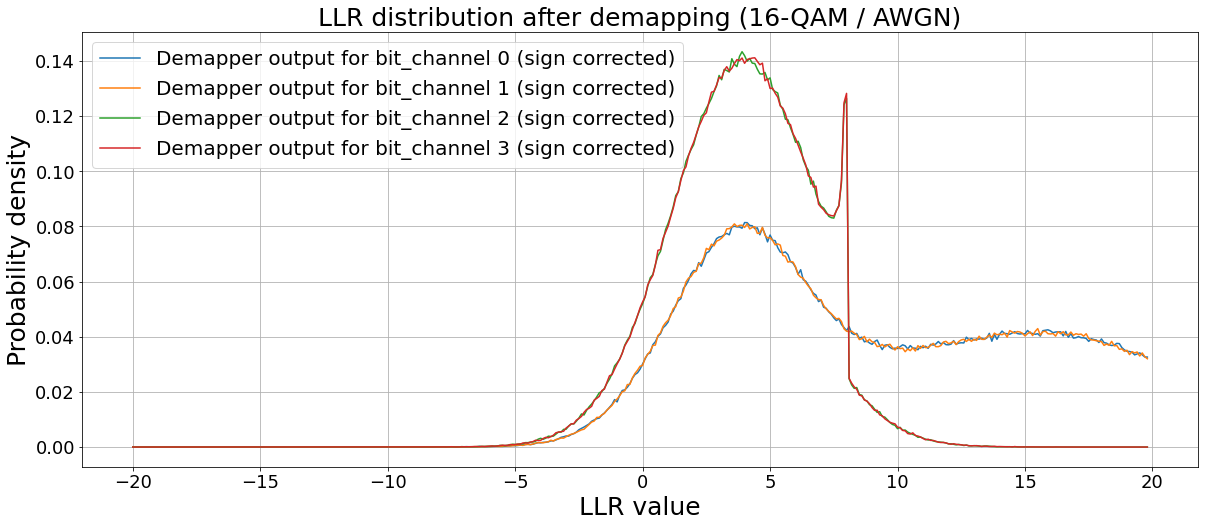

In [5]:
# simulation parameters
batch_size = int(1e6) # number of symbols to be analyzed
num_bits_per_symbol = 4 # bits per modulated symbol, i.e., 2^4 = 16-QAM
ebno_db = 4 # simulation SNR

# init system components
source = BinarySource() # generates random info bits

# we use a simple AWGN channel
channel = AWGN()

# calculate noise var for given Eb/No (no code used at the moment)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate=1) 

# and generate bins for the histogram
llr_bins = np.arange(-20,20,0.1)

# initialize mapper and demapper for constellation object
constellation = Constellation("qam", num_bits_per_symbol=num_bits_per_symbol)
mapper = Mapper(constellation=constellation)

# APP demapper
demapper = Demapper("app", constellation=constellation)

# Binary source that generates random 0s/1s
b = source([batch_size, num_bits_per_symbol])

# init mapper, channel and demapper
x = mapper(b)
y = channel([x, no])
llr = demapper([y, no])

# we flip the sign of all LLRs where b_i=0
# this ensures that all positive LLRs mark correct decisions
# all negative LLR values would lead to erroneous decisions
llr_b = tf.multiply(llr, (2.*b-1.))

# calculate LLR distribution for all bit-channels individually
llr_dist = []
for i in range(num_bits_per_symbol):
    
    llr_np = tf.reshape(llr_b[:,i],[-1]).numpy()    
    t, _ = np.histogram(llr_np, bins=llr_bins, density=True);
    llr_dist.append(t)

# and plot the results
plt.figure(figsize=(20,8))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which="both")
plt.xlabel("LLR value", fontsize=25)
plt.ylabel("Probability density", fontsize=25)
for idx, llr_hist in enumerate(llr_dist):
    leg_str = f"Demapper output for bit_channel {idx} (sign corrected)".format()
    plt.plot(llr_bins[:-1], llr_hist, label=leg_str)
plt.title("LLR distribution after demapping (16-QAM / AWGN)", fontsize=25)
plt.legend(fontsize=20);


This also shows up in the bit-wise BER without any forward-error correction (FEC). <a class="anchor" id="ber_per_bit"></a>

In [6]:
# calculate bitwise BERs

b_hat = hard_decisions(llr) # hard decide the LLRs

# each bit where b != b_hat is defines a decision error
# cast to tf.float32 to allow tf.reduce_mean operation
errors = tf.cast(tf.not_equal(b, b_hat), tf.float32)

# calculate ber PER bit_channel
# axis = 0 is the batch-dimension, i.e. contains individual estimates
# axis = 1 contains the m individual bit channels
ber_per_bit = tf.reduce_mean(errors, axis=0)

print("BER per bit-channel: ", ber_per_bit.numpy())

BER per bit-channel:  [0.039274 0.039197 0.078234 0.077881]


So far, we have not applied any outer channel coding. However, from the previous histograms it is obvious that the quality of the received LLRs depends bit index within a symbol. Further, LLRs may become correlated and each symbol error may lead to multiple erroneous received bits (mapped to the same symbol). 
The principle idea of BICM is to *break* the local dependencies by adding an interleaver between channel coding and mapper (or demapper and decoder, respectively).

For sufficiently long codes (and well-suited interleavers), the channel decoder effectively *sees* one channel.
This separation enables the - from engineering's perspective - simplified and elegant design of channel coding schemes based on binary bit-metric decoding while following Massey's original spirit that *the real goal of the modulation system is to create the “best” discrete memoryless channel (DMC) as seen by the coding system"* [1].



### Simple BER Simulations

We are now interested to simulate the BER of the BICM system including LDPC codes.
For this, we use the class `PlotBER` which essentially provides convenience functions for BER simulations.
It internally calls `sim_ber()` to simulate each SNR point until reaching a pre-defined target number of errors.

**Note**: a custom BER simulation is always possible. However, without early stopping the simulations can take significantly more simulation time and `PlotBER` directly stores the results internally for later comparison.

In [7]:
# generate new figure
ber_plot_allzero = PlotBER("BER Performance of All-zero Codeword Simulations")

# and define baseline
num_bits_per_symbol = 2 # QPSK
num_bp_iter = 20 # number of decoder iterations

# LDPC code parameters
k = 600 # number of information bits per codeword
n = 1200 # number of codeword bits

# and the initialize the LDPC encoder / decoder
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder, # connect encoder (for shared code parameters)
                        cn_type="boxplus-phi", # use the exact boxplus function
                        num_iter=num_bp_iter) 

# initialize a random interleaver and corresponding deinterleaver
interleaver = RandomInterleaver()
deinterleaver = Deinterleaver(interleaver)

# mapper and demapper
constellation = Constellation("qam", num_bits_per_symbol=num_bits_per_symbol)
mapper = Mapper(constellation=constellation)
demapper = Demapper("app", constellation=constellation) # APP demapper

# define system 
@tf.function() # we enable graph mode for faster simulations
def run_ber(batch_size, ebno_db):
    # calculate noise variance
    no = ebnodb2no(ebno_db,
                   num_bits_per_symbol=num_bits_per_symbol,
                   coderate=k/n)    
    u = source([batch_size, k]) # generate random bit sequence to transmit
    c = encoder(u) # LDPC encode (incl. rate-matching and CRC concatenation)
    c_int = interleaver(c)
    x = mapper(c_int) # map to symbol (QPSK)
    y = channel([x, no]) # transmit over AWGN channel
    llr_ch = demapper([y, no]) # demapp
    llr_deint = deinterleaver(llr_ch)
    u_hat = decoder(llr_deint) # run LDPC decoder (incl. de-rate-matching)

    return u, u_hat


We simulate the BER at each SNR point in `ebno_db` for a given `batch_size` of samples.
In total, per SNR point `max_mc_iter` batches are simulated.

To improve the simulation throughput, several optimizations are available:

1. ) Continue with next SNR point if `num_target_bit_errors` is reached (or `num_target_block_errors`).
2. ) Stop simulation if current SNR point returned no error (usually the BER is monotonic w.r.t. the SNR, i.e., a higher SNR point will also return BER=0)

**Note**: by setting `forward_keyboard_interrupt`=False, the simulation can be interrupted at any time and returns the intermediate results.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6451e-01 | 1.0000e+00 |       98705 |      600000 |         1000 |        1000 |         2.8 |reached target bit errors
     0.25 | 1.3982e-01 | 9.8800e-01 |       83894 |      600000 |          988 |        1000 |         0.1 |reached target bit errors
      0.5 | 1.0626e-01 | 9.2300e-01 |       63753 |      600000 |          923 |        1000 |         0.1 |reached target bit errors
     0.75 | 6.5253e-02 | 7.5400e-01 |       39152 |      600000 |          754 |        1000 |         0.1 |reached target bit errors
      1.0 | 2.9843e-02 | 4.6000e-01 |       17906 |      600000 |          460 |        1000 |         0.1 |reached target bit errors
     1.25 | 1.0292e-02 | 2.0900e-01 |        6175 |      600000 |          

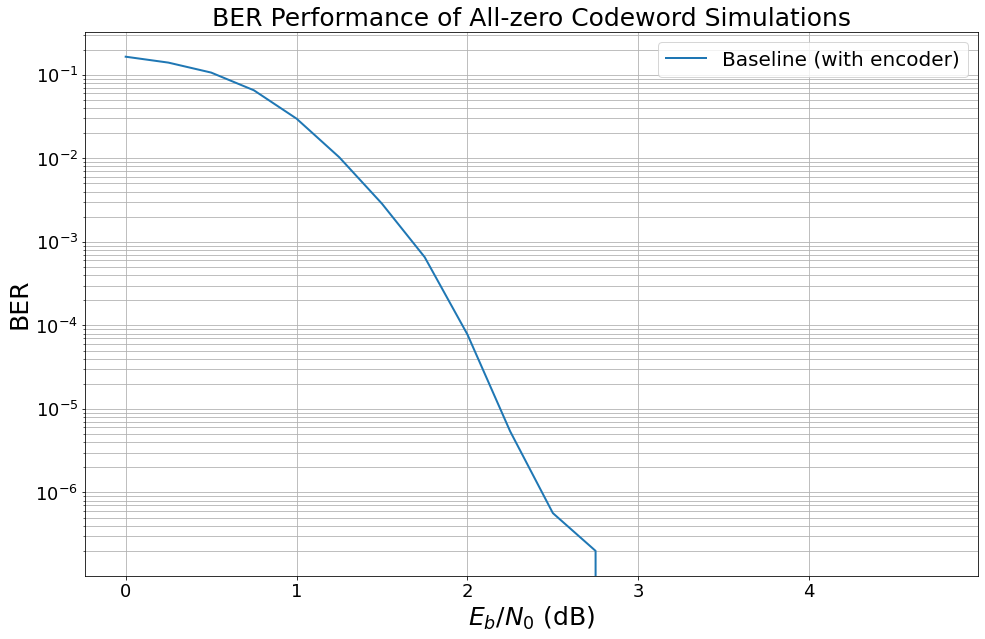

In [8]:
 # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
ber_plot_allzero.simulate(run_ber, # the function have defined previously
                          ebno_dbs=np.arange(0, 5, 0.25), # sim SNR range 
                          legend="Baseline (with encoder)",
                          max_mc_iter=50,
                          num_target_bit_errors=1000,
                          batch_size=1000,
                          soft_estimates=False,
                          early_stop=True,
                          show_fig=True,
                          forward_keyboard_interrupt=False);

## All-zero Codeword Simulations

In this section you will learn about how to simulate accurate BER curves without the need for having an actual encoder in-place.
We compare each step with the ground truth from the Sionna encoder:

1. ) Simulate baseline with encoder as done above.
2. ) Remove encoder: Simulate QPSK with all-zero codeword transmission.
3. ) Gaussian approximation (for BPSK/QPSK): Remove (de-)mapping and mimic the LLR distribution for the all-zero codeword.
4. ) Learn that a scrambler is required for higher order modulation schemes.

An important property of linear codes is that each codewords has - in average - the same behavior. Thus, for BER simulations the all-zero codeword is sufficient.

**Note**: strictly speaking, this requires *symmetric* decoders in a sense that the decoder is not biased towards positive or negative LLRs (e.g., by interpreting $\ell_\text{ch}=0$ as positive value). However, in practice this can be either avoided or is often neglected.

Recall that we have simulated the following setup as baseline.
Note: for simplicity and readability, the interleaver is omitted in the following.


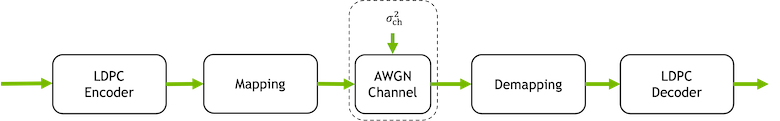

Let us implement a Keras model that can be re-used and configured for the later experiments.

In [9]:
class LDPC_QAM_AWGN(tf.keras.Model):
    """System model for channel coding BER simulations.
    
    This model allows to simulate BERs over an AWGN channel with
    QAM modulation. It can enable/disable multiple options to analyse all-zero codeword simulations.
    
    If active, the system uses the 5G LDPC encoder/decoder module.
    
    Parameters
    ----------
        k: int
            number of information bits per codeword.
        
        n: int 
            codeword length.
        
        num_bits_per_symbol: int
            number of bits per QAM symbol.
            
        demapping_method: str
            A string defining the demapping method. Can be either "app" or "maxlog".
            
        decoder_type: str
            A string defining the check node update function type of the LDPC decoder.
            
        use_allzero: bool  
            A boolean defaults to False. If True, no encoder is used and all-zero codewords are sent.
        
        use_scrambler: bool
            A boolean defaults to False. If True, a scrambler after the encoder and a descrambler before the decoder
            is used, respectively.

        use_ldpc_output_interleaver: bool
            A boolean defaults to False. If True, the output interleaver as 
            defined in 3GPP 38.212 is applied after rate-matching.
        
        no_est_mismatch: float
            A float defaults to 1.0. Defines the SNR estimation mismatch of the demapper such that the effective demapping
            noise variance estimate is the scaled by ``no_est_mismatch`` version of the true noise_variance
            
    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.
        
        ebno_db: float or tf.float
            A float defining the simulation SNR.
            
    Output
    ------
        (u, u_hat):
            Tuple:
        
        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.           

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.           
    """
    
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,
                 demapping_method="app",
                 decoder_type="boxplus",
                 use_allzero=False,
                 use_scrambler=False,
                 use_ldpc_output_interleaver=False,
                 no_est_mismatch=1.):
        super().__init__()
        self.k = k
        self.n = n

        self.num_bits_per_symbol = num_bits_per_symbol

        self.use_allzero = use_allzero
        self.use_scrambler = use_scrambler

        # adds noise to SNR estimation at demapper
        # see last section "mismatched demapping"
        self.no_est_mismatch = no_est_mismatch 

        # init components
        self.source = BinarySource()
       
        # initialize mapper and demapper with constellation object
        self.constellation = Constellation("qam",
                                num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method,
                                 constellation=self.constellation)

        self.channel = AWGN()

        # LDPC encoder / decoder
        if use_ldpc_output_interleaver:
            # the output interleaver needs knowledge of the modulation order
            self.encoder = LDPC5GEncoder(self.k, self.n, num_bits_per_symbol)
        else:
            self.encoder = LDPC5GEncoder(self.k, self.n)
        self.decoder = LDPC5GDecoder(self.encoder, cn_type=decoder_type)

        self.scrambler = Scrambler()        
        # connect descrambler to scrambler
        self.descrambler = Descrambler(self.scrambler, binary=False) 

    @tf.function() # enable graph mode for higher throughputs
    def call(self, batch_size, ebno_db):

        # calculate noise variance
        no = ebnodb2no(ebno_db,
                       num_bits_per_symbol=self.num_bits_per_symbol,
                       coderate=self.k/self.n)            

        if self.use_allzero:
            u = tf.zeros([batch_size, self.k]) # only needed for 
            c = tf.zeros([batch_size, self.n]) # replace enc. with all-zero codeword
        else:
            u = self.source([batch_size, self.k])
            c = self.encoder(u) # explicitly encode
        
        # scramble codeword if actively required
        if self.use_scrambler:
            c = self.scrambler(c)

        x = self.mapper(c) # map c to symbols

        y = self.channel([x, no]) # transmit over AWGN channel

        # add noise estimation mismatch for demapper (see last section)
        # set to 1 per default -> no mismatch
        no_est = no * self.no_est_mismatch
        llr_ch = self.demapper([y, no_est]) # demapp

        if self.use_scrambler:
            llr_ch = self.descrambler(llr_ch)

        u_hat = self.decoder(llr_ch) # run LDPC decoder (incl. de-rate-matching)

        return u, u_hat

### Remove Encoder: Simulate QPSK with All-zero Codeword Transmission

We now simulate the same system *without* encoder and transmit constant *0*s.

Due to the symmetry of the QPSK, no scrambler is required. You will learn about the effect of the scrambler in the last section.

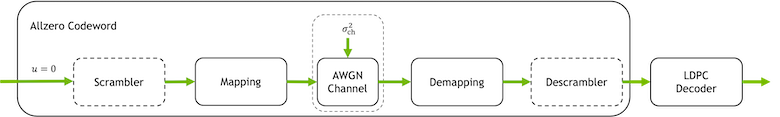

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6225e-01 | 1.0000e+00 |       97348 |      600000 |         1000 |        1000 |         0.7 |reached target bit errors
     0.25 | 1.3823e-01 | 9.9000e-01 |       82941 |      600000 |          990 |        1000 |         0.0 |reached target bit errors
      0.5 | 1.0630e-01 | 9.3400e-01 |       63783 |      600000 |          934 |        1000 |         0.0 |reached target bit errors
     0.75 | 6.3673e-02 | 7.5400e-01 |       38204 |      600000 |          754 |        1000 |         0.0 |reached target bit errors
      1.0 | 2.8445e-02 | 4.4100e-01 |       17067 |      600000 |          441 |        1000 |         0.0 |reached target bit errors
     1.25 | 1.0038e-02 | 2.1400e-01 |        6023 |      600000 |          

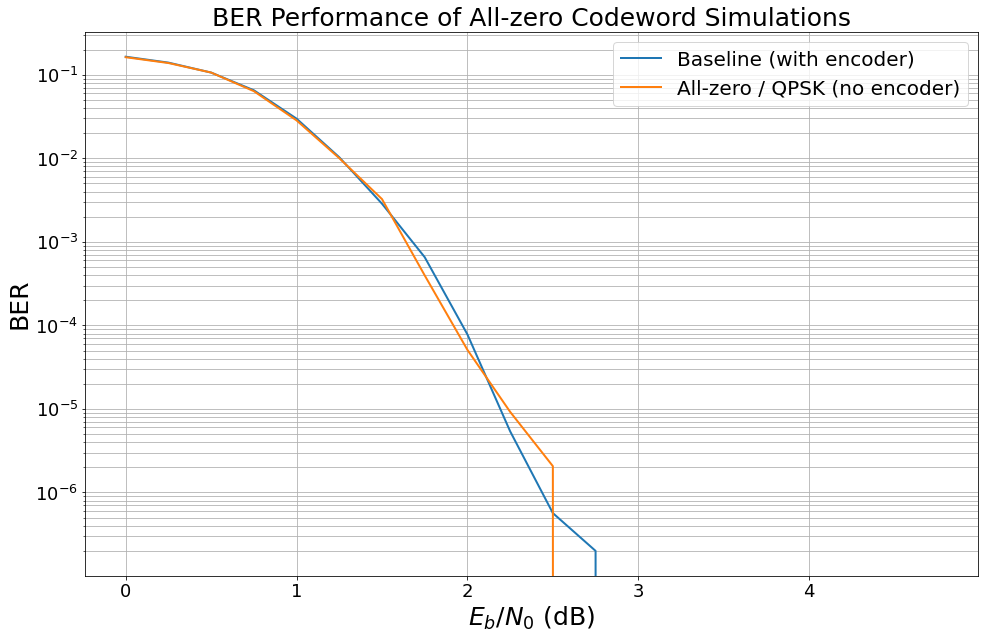

In [10]:
model_allzero = LDPC_QAM_AWGN(k,
                              n,
                              num_bits_per_symbol=2,
                              use_allzero=True, # disable encoder
                              use_scrambler=False) # we do not use a scrambler for the moment (QPSK!)

# and simulate the new curve
# Hint: as the model is callable, we can directly pass it to the 
# Monte Carlo simulation
ber_plot_allzero.simulate(model_allzero,
                          ebno_dbs=np.arange(0, 5, 0.25),
                          legend="All-zero / QPSK (no encoder)",
                          max_mc_iter=50,
                          num_target_bit_errors=1000,
                          batch_size=1000,
                          soft_estimates=False,
                          show_fig=True,
                          forward_keyboard_interrupt=False);

As expected, the BER curves are identical (within the accuracy of the Monte Carlo simulation).

### Remove (De-)Mapping: Approximate the LLR Distribution of the All-zero Codeword (and BPSK/QPSK)

For the all-zero codeword, the BPSK mapper generates the *all-one* signal (as each *0* is mapped to a *1*).

Assuming an AWGN channel with noise variance $\sigma_\text{ch}^2$, it holds that the output of the channel $y$ is Gaussian distributed with mean $\mu=1$ and noise variance $\sigma_\text{ch}^2$.
Demapping of the BPSK symbols is given as $\ell_\text{ch} = -\frac{2}{\sigma_\text{ch}^2}y$.

This leads to the effective LLR distribution of $\ell_\text{ch} \sim \mathcal{N}(-\frac{2}{\sigma_\text{ch}^2},\frac{4}{\sigma_\text{ch}^2})$ and, thereby, allows to mimic the mapper, AWGN channel and demapper by a Gaussian distribution.
The layer `GaussianPriorSource` provides such a source for arbitrary shapes.

The same derivation holds for QPSK. Let us quickly verify the correctness of these results by a Monte Carlo simulation.

**Note**: the negative sign for the BPSK demapping rule comes from the (in communications) unusual definition of logits $\ell = \operatorname{log} \frac{p(x=1)}{p(x=0)}$.

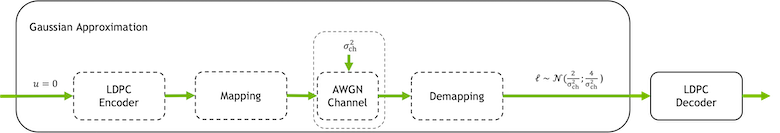

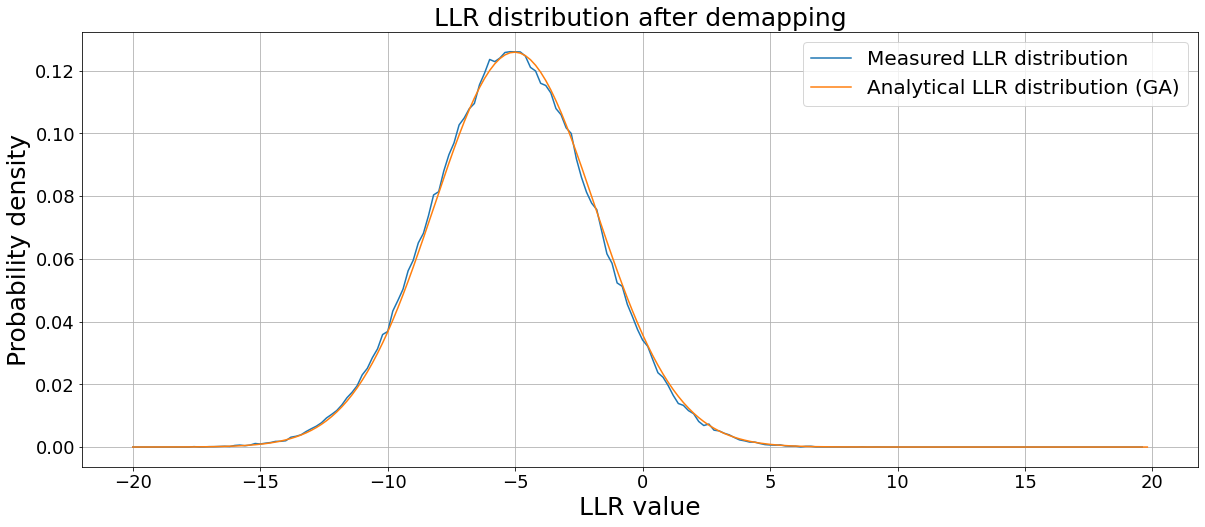

In [11]:
num_bits_per_symbol = 2 # we use QPSK
ebno_db = 4 # choose any SNR
batch_size = 100000 # we only simulate 1 symbol per batch

# calculate noise variance
no = ebnodb2no(ebno_db,
               num_bits_per_symbol=num_bits_per_symbol,
               coderate=k/n)  

# generate bins for the histogram
llr_bins = np.arange(-20, 20, 0.2)

c = tf.zeros([batch_size, num_bits_per_symbol]) # all-zero codeword
x = mapper(c) # mapped to constant symbol
y = channel([x, no])
llr = demapper([y, no]) # and generate LLRs

llr_dist, _ = np.histogram(llr.numpy() , bins=llr_bins, density=True);

# negative mean value due to different logit/llr definition 
# llr = log[(x=1)/p(x=0)]
mu_llr = -2 / no
no_llr = 4 / no

# generate Gaussian pdf
llr_pred = 1/np.sqrt(2*np.pi*no_llr) * np.exp(-(llr_bins-mu_llr)**2/(2*no_llr))

# and compare the results
plt.figure(figsize=(20,8))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which="both")
plt.xlabel("LLR value", fontsize=25)
plt.ylabel("Probability density", fontsize=25)
plt.plot(llr_bins[:-1], llr_dist, label="Measured LLR distribution")
plt.plot(llr_bins, llr_pred, label="Analytical LLR distribution (GA)")
plt.title("LLR distribution after demapping", fontsize=25)
plt.legend(fontsize=20);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6506e-01 | 9.9930e-01 |      990347 |     6000000 |         9993 |       10000 |         1.3 |reached target bit errors
     0.25 | 1.3984e-01 | 9.9030e-01 |      839044 |     6000000 |         9903 |       10000 |         0.4 |reached target bit errors
      0.5 | 1.0517e-01 | 9.3200e-01 |      631049 |     6000000 |         9320 |       10000 |         0.4 |reached target bit errors
     0.75 | 6.5437e-02 | 7.6580e-01 |      392623 |     6000000 |         7658 |       10000 |         0.4 |reached target bit errors
      1.0 | 3.1496e-02 | 4.7400e-01 |      188979 |     6000000 |         4740 |       10000 |         0.4 |reached target bit errors
     1.25 | 1.0650e-02 | 2.0850e-01 |       63902 |     6000000 |         2

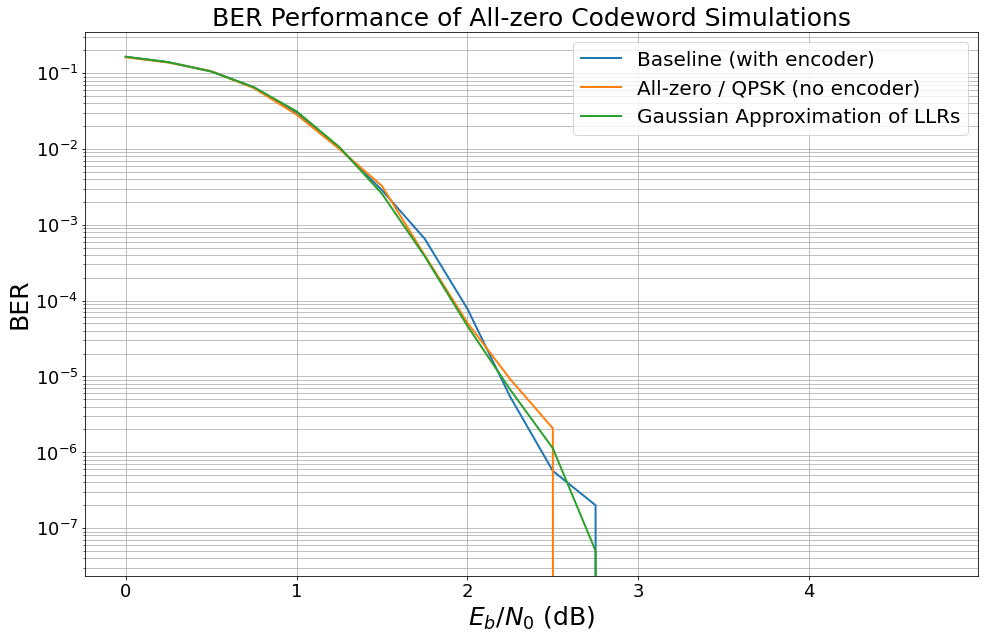

In [12]:
num_bits_per_symbol = 2 # QPSK 

# initialize LLR source
ga_source = GaussianPriorSource()

@tf.function() # enable graph mode
def run_ber_ga(batch_size, ebno_db):
    # calculate noise variance
    no = ebnodb2no(ebno_db,
                   num_bits_per_symbol=num_bits_per_symbol,
                   coderate=k/n)    
    
    u = tf.zeros([batch_size, k]) # only needed for ber calculations
    
    llr_ch = ga_source([[batch_size, n], no]) # generate LLRs directly
    u_hat = decoder(llr_ch) # run LDPC decoder (incl. de-rate-matching)

    return u, u_hat

# and simulate the new curve
ber_plot_allzero.simulate(run_ber_ga,
                          ebno_dbs=np.arange(0, 5, 0.25), # simulation SNR,
                          max_mc_iter=50,
                          num_target_bit_errors=1000,
                          legend="Gaussian Approximation of LLRs",
                          batch_size = 10000,
                          soft_estimates=False,
                          show_fig=True,
                          forward_keyboard_interrupt=False);

### The Role of the Scrambler

So far, we have seen that the all-zero codeword yields the same error-rates as any other sequence.
Intuitively, the *all-zero codeword trick* generates a constant stream of *0*s at the input of the mapper.
However, if the channel is not symmetric we need to ensure that we capture the *average* behavior of all possible symbols equally.
Mathematically this symmetry condition can be expressed as $p(Y=y|c=0)=p(Y=-y|c=1)$

As shown in the previous experiments, for QPSK both *bit-channels* have the same behavior but for 16-QAM systems this does not hold anymore and our simulated BER does not represent the average decoding performance of the original system. 

One possible solution is to scramble the all-zero codeword before transmission and descramble the received LLRs before decoding (i.e., flip the sign accordingly). 
This ensures that the mapper/demapper (+channel) operate on (pseudo-)random data, but from decoder's perspective the the all-zero codeword assumption is still valid. This avoids the need for an actual encoder. For further details, we refer to *i.i.d. channel adapters* in [9].

**Note**: another example is that the recorded LLRs can be even used to evaluate different codes as the all-zero codeword is a valid codeword for all linear codes. Going one step further, one can even simulate codes of different rates with the same pre-recorded LLRs.

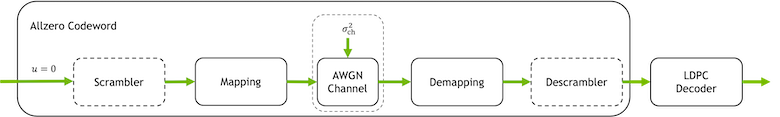

In [13]:
# we generate a new plot
ber_plot_allzero16qam = PlotBER("BER Performance for 64-QAM")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.4823e-01 | 1.0000e+00 |      148935 |      600000 |         1000 |        1000 |         0.6 |reached target bit errors
     0.25 | 2.4005e-01 | 1.0000e+00 |      144029 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      0.5 | 2.3212e-01 | 1.0000e+00 |      139273 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
     0.75 | 2.2350e-01 | 1.0000e+00 |      134100 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      1.0 | 2.1467e-01 | 1.0000e+00 |      128802 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
     1.25 | 2.0421e-01 | 1.0000e+00 |      122527 |      600000 |         1

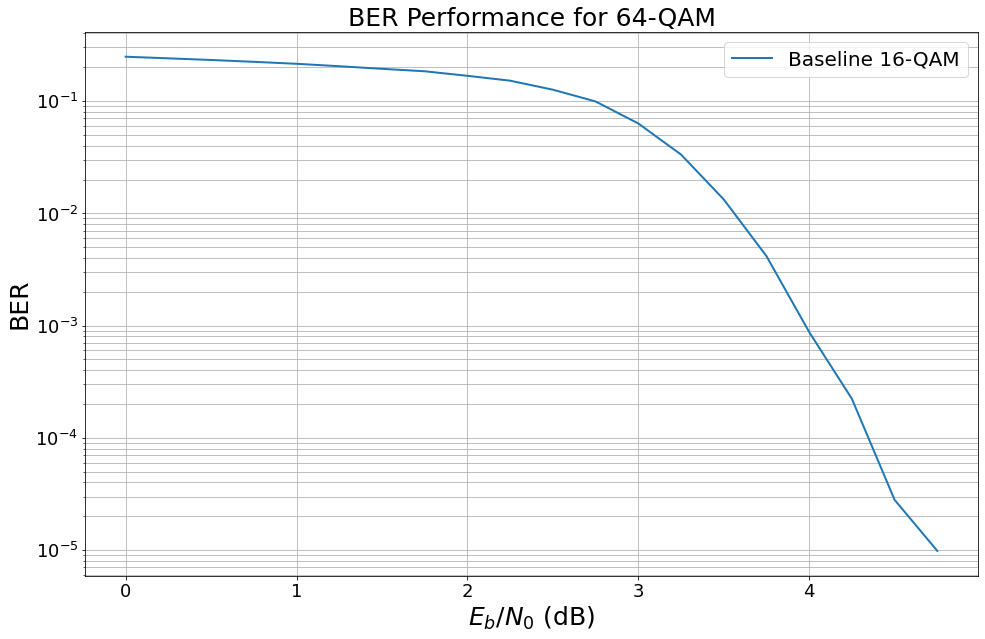

In [14]:
# simulate a new baseline for 16-QAM
model_baseline_16 = LDPC_QAM_AWGN(k,
                                  n,
                                  num_bits_per_symbol=4,
                                  use_allzero=False, # baseline without all-zero
                                  use_scrambler=False)


# and simulate the new curve
# Hint: as the model is callable, we can directly pass it to the 
# Monte Carlo simulation
ber_plot_allzero16qam.simulate(model_baseline_16,
                               ebno_dbs=np.arange(0, 5, 0.25),
                               legend="Baseline 16-QAM",
                               max_mc_iter=50,
                               num_target_bit_errors=2000,
                               batch_size=1000,
                               soft_estimates=False,
                               show_fig=True,
                               forward_keyboard_interrupt=False);

We now apply the *all-zero trick* as above and simulate ther BER performance without scrambling.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.0219e-01 | 1.0000e+00 |      181313 |      600000 |         1000 |        1000 |         0.6 |reached target bit errors
     0.25 | 2.9814e-01 | 1.0000e+00 |      178883 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      0.5 | 2.9287e-01 | 1.0000e+00 |      175723 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
     0.75 | 2.8685e-01 | 1.0000e+00 |      172110 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      1.0 | 2.8033e-01 | 1.0000e+00 |      168200 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
     1.25 | 2.7465e-01 | 1.0000e+00 |      164788 |      600000 |         1

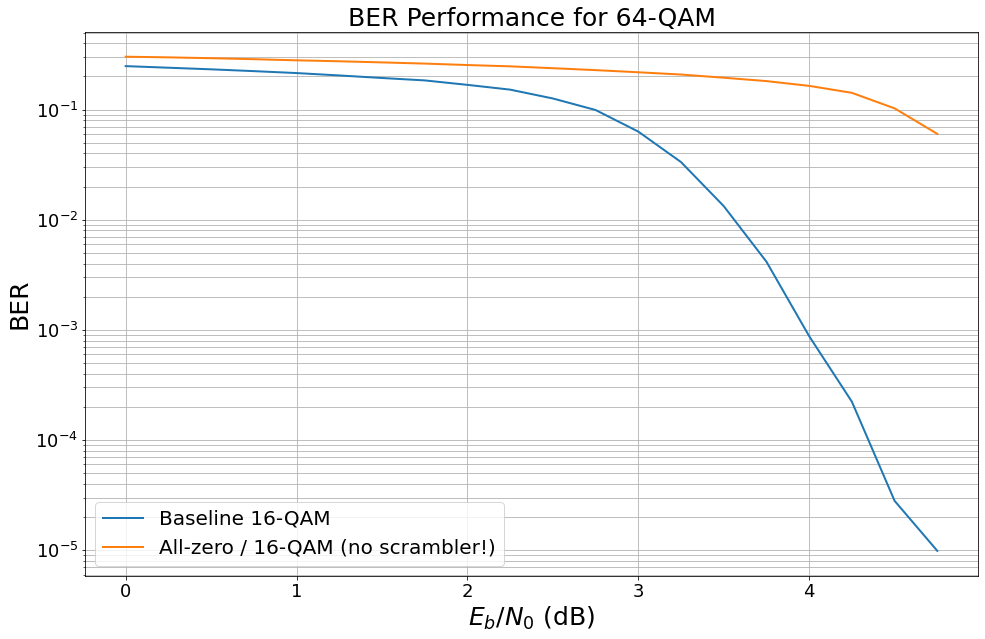

In [15]:
# and repeat the experiment for a 16QAM WITHOUT scrambler 
model_allzero_16_no_sc = LDPC_QAM_AWGN(k,
                                       n,
                                       num_bits_per_symbol=4,
                                       use_allzero=True, # all-zero codeword
                                       use_scrambler=False) # no scrambler used


# and simulate the new curve
# Hint: as the model is callable, we can directly pass it to the 
# Monte Carlo simulation
ber_plot_allzero16qam.simulate(model_allzero_16_no_sc,
                               ebno_dbs=np.arange(0, 5, 0.25),
                               legend="All-zero / 16-QAM (no scrambler!)",
                               max_mc_iter=50,
                               num_target_bit_errors=1000,
                               batch_size=1000,
                               soft_estimates=False,
                               show_fig=True,
                               forward_keyboard_interrupt=False);

As expected the results are wrong as we have transmitted all bits over the *less reliable* channel (cf [BER per bit-channel](#Constellations-and-Bit-Channels)).

Let us repeat this experiment with scrambler and descrambler at the correct position.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.4735e-01 | 1.0000e+00 |      148407 |      600000 |         1000 |        1000 |         0.9 |reached target bit errors
     0.25 | 2.4123e-01 | 1.0000e+00 |      144737 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      0.5 | 2.3287e-01 | 1.0000e+00 |      139721 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
     0.75 | 2.2510e-01 | 1.0000e+00 |      135062 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      1.0 | 2.1514e-01 | 1.0000e+00 |      129083 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
     1.25 | 2.0605e-01 | 1.0000e+00 |      123628 |      600000 |         1

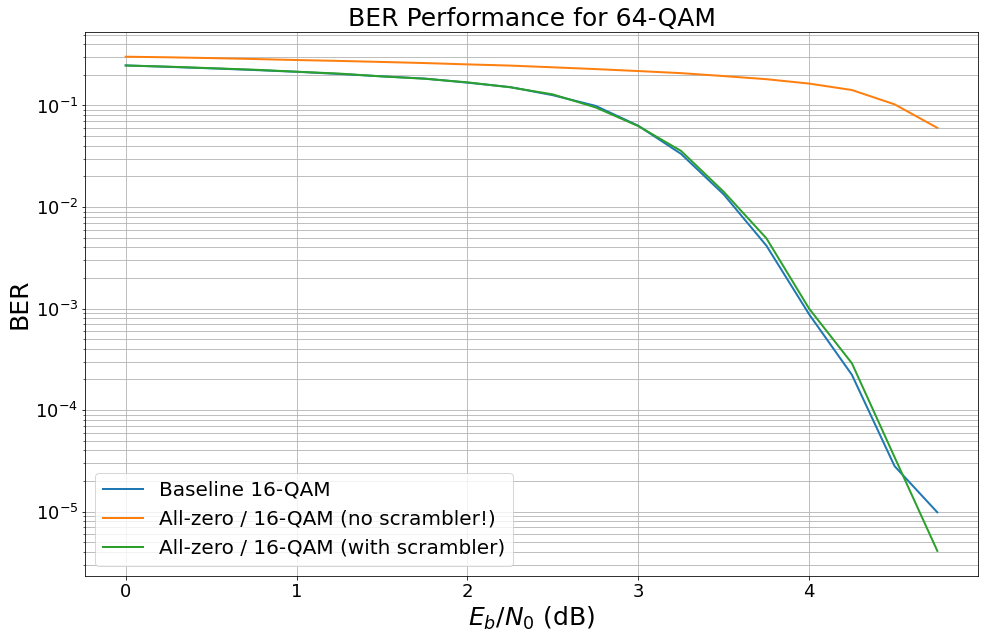

In [16]:
# and repeat the experiment for a 16QAM WITHOUT scrambler 
model_allzero_16_sc = LDPC_QAM_AWGN(k,
                                    n,
                                    num_bits_per_symbol=4,
                                    use_allzero=True, # all-zero codeword
                                    use_scrambler=True) # activate scrambler


# and simulate the new curve
# Hint: as the model is callable, we can directly pass it to the 
# Monte Carlo simulation
ber_plot_allzero16qam.simulate(model_allzero_16_sc,
                               ebno_dbs=np.arange(0, 5, 0.25),
                               legend="All-zero / 16-QAM (with scrambler)",
                               max_mc_iter=50,
                               num_target_bit_errors=1000,
                               batch_size=1000,
                               soft_estimates=False,
                               show_fig=True,
                               forward_keyboard_interrupt=False);

The 5G standard defines an additional output interleaver after the rate-matching (see Sec. 5.4.2.2 in [11]).

We now activate this additional interleaver to enable additional BER gains.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.9663e-01 | 1.0000e+00 |      117980 |      600000 |         1000 |        1000 |         0.7 |reached target bit errors
     0.25 | 1.9138e-01 | 1.0000e+00 |      114830 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      0.5 | 1.8279e-01 | 1.0000e+00 |      109673 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
     0.75 | 1.7542e-01 | 1.0000e+00 |      105255 |      600000 |         1000 |        1000 |         0.1 |reached target bit errors
      1.0 | 1.6715e-01 | 1.0000e+00 |      100289 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
     1.25 | 1.5677e-01 | 1.0000e+00 |       94061 |      600000 |         1

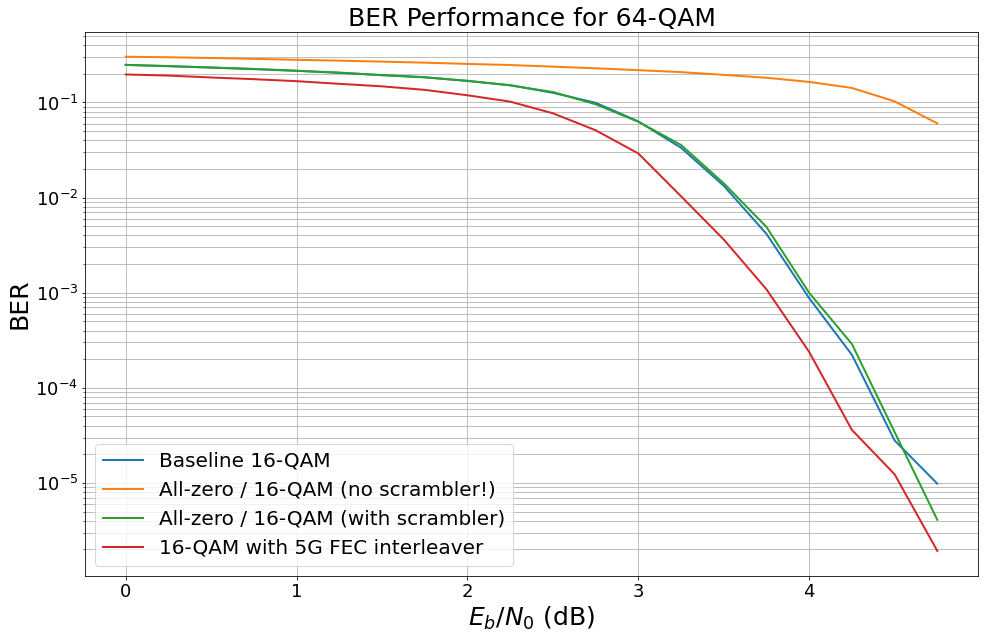

In [17]:
# activate output interleaver
model_output_interleaver= LDPC_QAM_AWGN(k,
                                        n,
                                        num_bits_per_symbol=4,
                                        use_ldpc_output_interleaver=True, 
                                        use_allzero=False, 
                                        use_scrambler=False)


# and simulate the new curve
# Hint: as the model is callable, we can directly pass it to the 
# Monte Carlo simulation
ber_plot_allzero16qam.simulate(model_output_interleaver,
                               ebno_dbs=np.arange(0, 5, 0.25),
                               legend="16-QAM with 5G FEC interleaver",
                               max_mc_iter=50,
                               num_target_bit_errors=1000,
                               batch_size=1000,
                               soft_estimates=False,
                               show_fig=True,
                               forward_keyboard_interrupt=False);

## EXIT Charts

You now learn about how the convergence behavior of iterative receivers can be visualized. 

Extrinsic Information Transfer (EXIT) charts [7] are a widely adopted tool to analyze the convergence behavior of iterative receiver algorithms. The principle idea is to treat each component decoder (or demapper etc.) as individual entity with its own EXIT characteristic.
EXIT charts not only allow to predict the decoding behavior (*open decoding tunnel*) but also enable LDPC code design (cf. [8]). However, this is beyond the scope of this notebook.

We can analytically derive the EXIT characteristic for check node (CN) and variable node (VN) decoder for a given code with `get_exit_analytic`.
Further, if the `LDPCBPDecoder` is initialized with option `track_exit`=True, it internally stores the average extrinsic mutual information after each iteration at the output of the VN/CN decoder.

Please note that this is only an approximation for the AWGN channel and assumes infinite code length. However, it turns out that the results are often accurate enough and 


n: 648, k: 324, coderate: 0.500


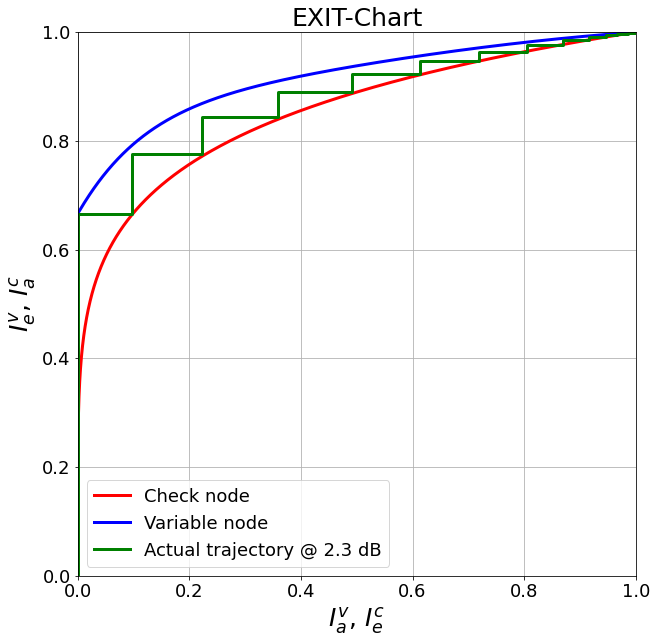

In [18]:
# parameters
ebno_db = 2.3
batch_size = 10000
num_bits_per_symbol = 2

pcm_id = 4 # decide which parity check matrix should be used (0-2: BCH; 3: (3,6)-LDPC 4: LDPC 802.11n
pcm, k_exit, n_exit, coderate = load_parity_check_examples(pcm_id, verbose=True)

# init components    
decoder_exit = LDPCBPDecoder(pcm, 
                             hard_out=False, 
                             cn_type="boxplus", 
                             trainable=False,
                             track_exit=True,
                             num_iter=20)

# generates fake llrs as if the all-zero codeword was transmitted over an AWNG channel with BPSK modulation (see early sections)
llr_source = GaussianPriorSource()

noise_var = ebnodb2no(ebno_db=ebno_db,
                      num_bits_per_symbol=num_bits_per_symbol,
                      coderate=coderate)

# use fake llrs from GA
llr = llr_source([[batch_size, n_exit], noise_var])

# simulate free runing trajectory
decoder_exit(llr)

# calculate analytical EXIT characteristics
# Hint: these curves assume asymptotic code length, i.e., may become inaccurate in the short length regime
Ia, Iev, Iec = get_exit_analytic(pcm, ebno_db)

# and plot the EXIT curves
plt = plot_exit_chart(Ia, Iev, Iec)

# however, as track_exit=True, the decoder logs the actual exit trajectory during decoding. This can be accessed by decoder.ie_v/decoder.ie_c after the simulation

# and add simulated trajectory to plot
plot_trajectory(plt, decoder_exit.ie_v, decoder_exit.ie_c, ebno_db)

As can be seen, the simulated trajectory of the decoder matches (relatively) well with the predicted
EXIT functions of the VN and CN decoder, respectively.

A few things to try:

- Change the SNR; which curves change? Why is one curve constant? Hint: does every component directly *see* the channel?
- What happens for other codes?
- Can you predict the *threshold* of this curve (i.e., the minimum SNR required for successful decoding)
- Verify the correctness of this threshold via BER simulations (hint: the codes are relatively short, thus the prediction is less accurate)

## Mismatched Demapping and the Advantages of Min-sum Decoding

So far, we have demapped with exact knowledge of the underlying noise distribution (including the exact SNR).
However, in practice estimating the SNR can be a complicated task and, as such, the estimated SNR used for demapping can be inaccurate.

In this part, you will learn about the advantages of min-sum decoding and we will see that it is more robust against mismatched demapping.

In [19]:
# let us first remove the non-scrambled result from the previous experiment
ber_plot_allzero16qam.remove(idx=1) # remove curve with index 1

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.9167e-01 | 1.0000e+00 |      175004 |      600000 |         1000 |        1000 |         0.6 |reached target bit errors
      0.5 | 2.7983e-01 | 1.0000e+00 |      167896 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      1.0 | 2.6990e-01 | 1.0000e+00 |      161938 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      1.5 | 2.5992e-01 | 1.0000e+00 |      155954 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      2.0 | 2.4621e-01 | 1.0000e+00 |      147729 |      600000 |         1000 |        1000 |         0.0 |reached target bit errors
      2.5 | 2.3175e-01 | 1.0000e+00 |      139048 |      600000 |         1

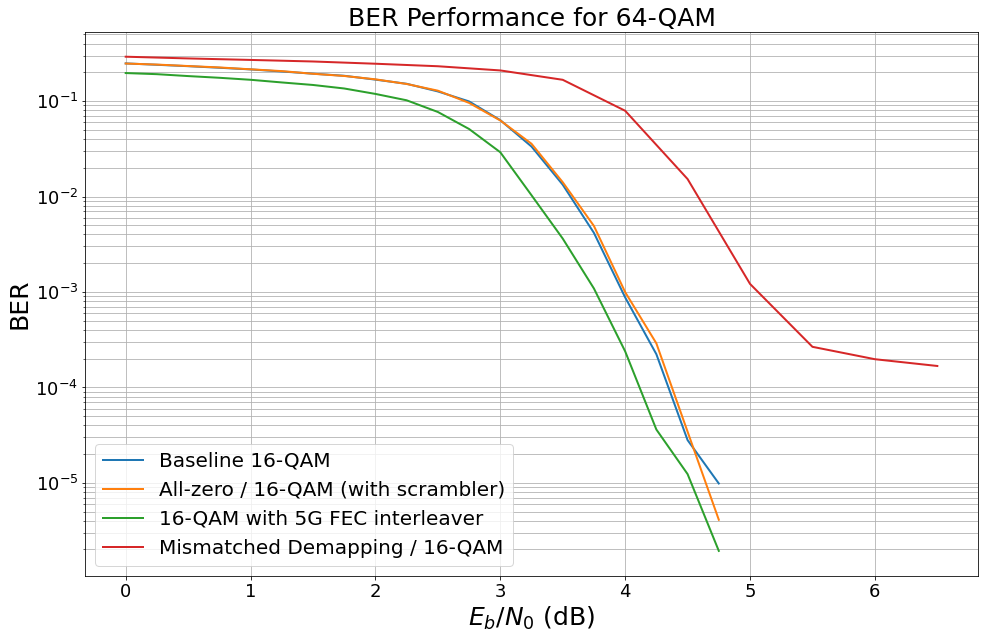

In [20]:
# simulate with mismatched noise estimation
model_allzero_16_no = LDPC_QAM_AWGN(k,
                                    n,
                                    num_bits_per_symbol=4,
                                    use_allzero=False, # full simulation
                                    no_est_mismatch=0.15) # noise variance estimation mismatch (no scaled by 0.15 )
                                     
ber_plot_allzero16qam.simulate(model_allzero_16_no,
                               ebno_dbs=np.arange(0, 7, 0.5),
                               legend="Mismatched Demapping / 16-QAM",
                               max_mc_iter=50,
                               num_target_bit_errors=1000,
                               batch_size=1000,
                               soft_estimates=False,
                               show_fig=True,
                               forward_keyboard_interrupt=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.9673e-01 | 1.0000e+00 |      178038 |      600000 |         1000 |        1000 |         1.6 |reached target bit errors
      0.5 | 2.8642e-01 | 1.0000e+00 |      171853 |      600000 |         1000 |        1000 |         0.1 |reached target bit errors
      1.0 | 2.7497e-01 | 1.0000e+00 |      164979 |      600000 |         1000 |        1000 |         0.1 |reached target bit errors
      1.5 | 2.6341e-01 | 1.0000e+00 |      158046 |      600000 |         1000 |        1000 |         0.1 |reached target bit errors
      2.0 | 2.5386e-01 | 1.0000e+00 |      152316 |      600000 |         1000 |        1000 |         0.1 |reached target bit errors
      2.5 | 2.3969e-01 | 1.0000e+00 |      143816 |      600000 |         1

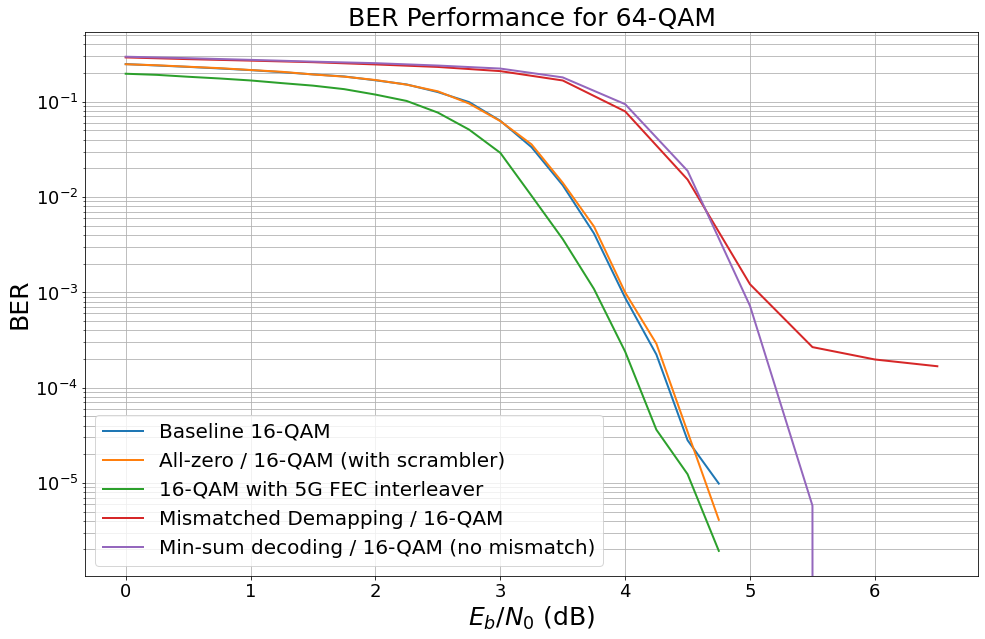

In [21]:
# simulate with mismatched noise estimation
model_allzero_16_ms = LDPC_QAM_AWGN(k,
                                    n,
                                    num_bits_per_symbol=4,
                                    use_allzero=False, # full simulation
                                    decoder_type="minsum", # activate min-sum decoding
                                    no_est_mismatch=1.) # no mismatch
                                     
ber_plot_allzero16qam.simulate(model_allzero_16_ms,
                               ebno_dbs=np.arange(0, 7, 0.5),
                               legend="Min-sum decoding / 16-QAM (no mismatch)",
                               max_mc_iter=50,
                               num_target_bit_errors=1000,
                               batch_size=1000,
                               soft_estimates=False,
                               show_fig=True,
                               forward_keyboard_interrupt=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.9721e-01 | 1.0000e+00 |      178324 |      600000 |         1000 |        1000 |         1.4 |reached target bit errors
      0.5 | 2.8528e-01 | 1.0000e+00 |      171168 |      600000 |         1000 |        1000 |         0.1 |reached target bit errors
      1.0 | 2.7617e-01 | 1.0000e+00 |      165701 |      600000 |         1000 |        1000 |         0.1 |reached target bit errors
      1.5 | 2.6409e-01 | 1.0000e+00 |      158451 |      600000 |         1000 |        1000 |         0.1 |reached target bit errors
      2.0 | 2.5094e-01 | 1.0000e+00 |      150564 |      600000 |         1000 |        1000 |         0.1 |reached target bit errors
      2.5 | 2.3911e-01 | 1.0000e+00 |      143464 |      600000 |         1

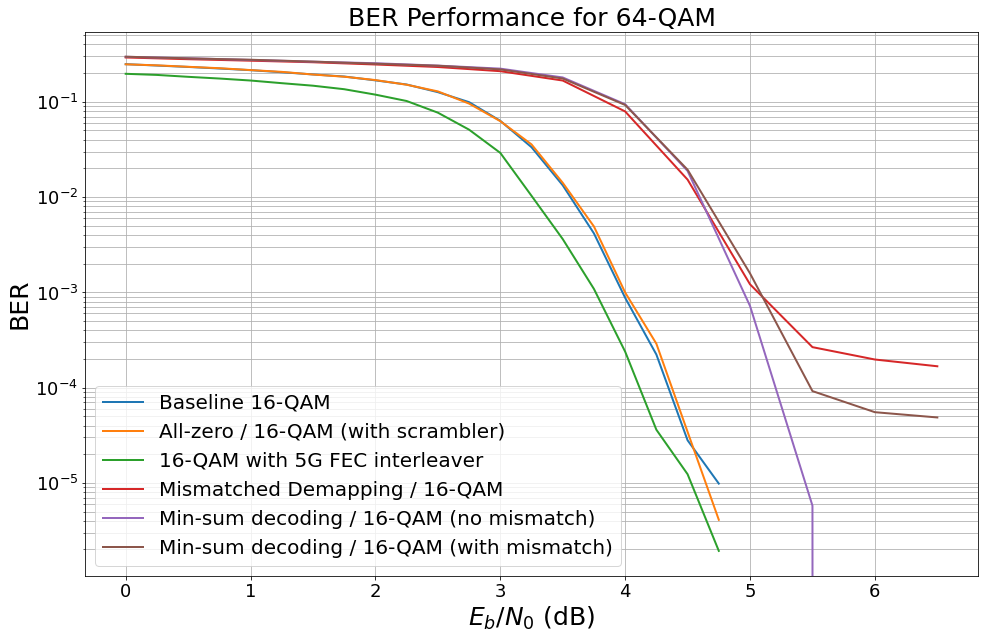

In [22]:
# simulate with mismatched noise estimation
model_allzero_16_ms = LDPC_QAM_AWGN(k,
                                    n,
                                    num_bits_per_symbol=4,
                                    use_allzero=False, # full simulation
                                    decoder_type="minsum", # activate min-sum decoding
                                    no_est_mismatch=0.15) # noise_var mismatch at demapper
                                     
ber_plot_allzero16qam.simulate(model_allzero_16_ms,
                            ebno_dbs=np.arange(0, 7, 0.5),
                            legend="Min-sum decoding / 16-QAM (with mismatch)",
                            max_mc_iter=50,
                            num_target_bit_errors=1000,
                            batch_size=1000,
                            soft_estimates=False,
                            show_fig=True,
                            forward_keyboard_interrupt=False);

Interestingly, *min-sum* decoding is more robust w.r.t. inaccurate LLR estimations. 
It is worth mentioning that *min-sum* decoding itself causes a performance loss. However, more advanced min-sum-based decoding approaches (offset-corrected min-sum) can operate close to *full BP* decoding.

You can also try:

- What happens with max-log demapping?
- Implement offset corrected min-sum decoding
- Have a closer look at the error-floor behavior
- Apply the concept of [Weighted BP](https://nvlabs.github.io/sionna/examples/Weighted_BP_Algorithm.html) to mismatched demapping

## References

[1] E. Zehavi, "8-PSK Trellis Codes for a Rayleigh Channel," IEEE Transactions on Communications, vol. 40, no. 5, 1992.

[2] G. Caire, G. Taricco and E. Biglieri, "Bit-interleaved Coded Modulation," IEEE Transactions on Information Theory, vol. 44, no. 3, 1998.

[3] G. Ungerböck, "Channel Coding with Multilevel/Phase Signals."IEEE Transactions on Information Theory, vol. 28, no. 1, 1982.

[4] J. L. Massey, “Coding and modulation in digital communications,” in Proc. Int. Zurich Seminar Commun., 1974.

[5] G. Böcherer, "Principles of Coded Modulation," Habilitation thesis, Tech. Univ. Munich, Munich, Germany, 2018.

[6] F. Schreckenbach, "Iterative Decoding of Bit-Interleaved Coded Modulation", PhD thesis, Tech. Univ. Munich, Munich, Germany, 2007.

[7] S. ten Brink, “Convergence Behavior of Iteratively Decoded Parallel Concatenated Codes,” IEEE Transactions on Communications, vol. 49, no. 10, pp. 1727-1737, 2001.

[8] S. ten Brink, G. Kramer, and A. Ashikhmin, “Design of low-density parity-check codes for modulation and detection,” IEEE Trans. Commun., vol. 52, no. 4, pp. 670–678, Apr. 2004.

[9] J. Hou, P. H. Siegel, L. B. Milstein, and H. D. Pfister, “Capacity-approaching bandwidth-efficient coded modulation schemes based on low-density parity-check codes,” IEEE Trans. Inform. Theory, vol. 49, no. 9, pp. 2141–2155, 2003.

[10] A. Alvarado, L. Szczecinski, R. Feick, and L. Ahumada, "Distribution of L-values in Gray-mapped M 2-QAM: Closed-form approximations and applications," IEEE Transactions on Communications, vol. 57, no. 7, pp. 2071-2079, 2009.

[11] ETSI 3GPP TS 38.212 “5G NR Multiplexing and channel coding”, v.16.5.0, 2021-03.